In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from matplotlib import pyplot as plt

from typing import List

import numpy as np
from scipy.stats import kendalltau
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sgp.trees.boosting import Boosting, L2Loss, PairwiseLL
from sgp.trees.forest import RandomForest
from sgp.trees.loss import MSELoss, MSEUpliftLoss
from sgp.trees.tree import DecisionTree, DecisionTreeModel
from sgp.tests.test_trees import benchmark_tree
from sgp.trees.binarizer import Binarizer

In [3]:
ds = load_boston()

X = ds['data']
y = ds['target']
xnames = ds['feature_names']
print(ds['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [5]:
forest = RandomForest(max_depth=6, n_trees=400, n_bins=128, random_state=31, n_jobs=5, verbose=False)
trees = forest.fit(X_train, MSELoss().point_stats(y_train), MSELoss(min_samples_leaf=10))

In [6]:
predicts = trees.predict(X_test)
r2_score(y_test, predicts)

0.7261887311191795

In [7]:
bin_importances = trees.importances()
feature_importances = np.sum(bin_importances, axis=1)
top_features = np.argsort(-feature_importances)
xnames[top_features]

array(['LSTAT', 'RM', 'CRIM', 'NOX', 'DIS', 'PTRATIO', 'TAX', 'AGE', 'B',
       'RAD', 'INDUS', 'ZN', 'CHAS'], dtype='<U7')

In [8]:
result, std = trees.pdp()

for i in top_features[:1]:
    plt.plot(trees.binarizer.boundaries[i], result[i])
    plt.fill_between(trees.binarizer.boundaries[i], result[i] - 3 * std[i], result[i] + 3 * std[i], alpha=0.1)

    plt.xlabel(xnames[i])
    plt.show()

TypeError: 'tuple' object cannot be interpreted as an integer

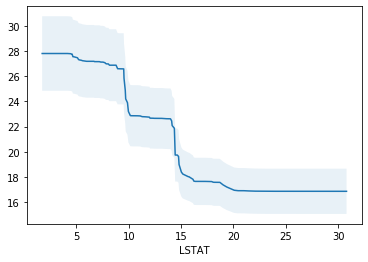

In [194]:
result, std = trees.pdp()

for i in top_features[:1]:
    plt.plot(trees.binarizer.boundaries[i], result[i])
    plt.fill_between(trees.binarizer.boundaries[i], result[i] - 3 * std[i], result[i] + 3 * std[i], alpha=0.1)

    plt.xlabel(xnames[i])
    plt.show()

# Binarizer

In [2]:
import scipy.stats
import numpy as np

In [3]:
X = scipy.stats.norm(0, 1).rvs((200000, 500))
y = np.mean(X, axis=1)
binarizer = Binarizer(32)

In [11]:
%%timeit n=5
binarizer.fit(X)

422 ms ± 9.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit n=5
df_bins = binarizer.transform(X)

7.18 s ± 253 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit n=5
df_bins = binarizer.transform(X)

1.86 s ± 23.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit n=5
DecisionTree(max_depth=6, binarizer=binarizer).fit(df_bins, MSELoss.point_stats(y), MSELoss(min_samples_leaf=1), binarize=False)

1.82 s ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%%timeit n=5
DecisionTree(max_depth=6, binarizer=binarizer).fit(df_bins, MSELoss.point_stats(y), MSELoss(min_samples_leaf=1), binarize=False)

3.03 s ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%time
benchmark_tree()

CPU times: user 38.3 s, sys: 1.15 s, total: 39.4 s
Wall time: 39.1 s


In [16]:
%%time
benchmark_tree()

CPU times: user 11.5 s, sys: 969 ms, total: 12.4 s
Wall time: 12.1 s


In [21]:
%%time
benchmark_tree(max_depth=1)

CPU times: user 9.04 s, sys: 473 ms, total: 9.51 s
Wall time: 8.98 s


In [9]:
%load_ext line_profiler

In [10]:
%lprun -f DecisionTree.eval_stats benchmark_tree()

Timer unit: 1e-06 s

Total time: 1.48469 s
File: ../sgp/trees/tree.py
Function: eval_stats at line 108

Line #      Hits         Time  Per Hit   % Time  Line Contents
   108                                               @staticmethod
   109                                               def eval_stats(df_bins: np.ndarray,
   110                                                              items_leafs: np.ndarray,
   111                                                              point_stats: np.ndarray,
   112                                                              depth: int,
   113                                                              n_bins: int) -> np.ndarray:
   114                                                   # Use a single array for two axes to optimize bincount function call
   115         6         29.0      4.8      0.0          leafs_shape = (2 ** depth + (2 ** depth - 1))
   116         6          6.0      1.0      0.0          leaf_bin_axis_shape = leafs_s

In [58]:
%lprun -f DecisionTree.fit benchmark_tree()

Timer unit: 1e-06 s

Total time: 7.54812 s
File: ../sgp/trees/tree.py
Function: fit at line 22

Line #      Hits         Time  Per Hit   % Time  Line Contents
    22                                               def fit(self, X: np.ndarray,
    23                                                       point_stats: np.ndarray,
    24                                                       loss: AdditiveLoss,
    25                                                       binarize: bool = True) -> 'DecisionTreeModel':
    26         1      29682.0  29682.0      0.4          assert_all_finite(X)
    27         1        227.0    227.0      0.0          assert_all_finite(point_stats)
    28                                           
    29         1    5888187.0 5888187.0     78.0          df_bins, binarizer = DecisionTree.check_input(X, self.binarizer, self.n_bins, binarize)
    30         1          2.0      2.0      0.0          assert binarizer.boundaries is not None
    31         1         

# Uplift

In [2]:
from sgp.tests.test_uplift import make_dataset
X, tr, y = make_dataset(100000)
f_names = ['f1', 'f2', 'f3', 'f4', 'f5']

In [3]:
from sgp.trees.loss import MSEUpliftLoss

tree = DecisionTree(max_depth=3, n_bins=64, verbose=False)
tree_model = tree.fit(X, MSEUpliftLoss.point_stats(y, tr), MSEUpliftLoss())
print(tree_model.pretty_str(f_names))

f1>=2.1308806813596743 [uplift=1.21, n=49738#50262, score=-1.5]
├── f2>=1.8763857479493475 [uplift=3.76, n=811#778, score=-1.4e+01]
│   ├── [uplift=4.86, n=23#32, score=-2.4e+01]
│   └── f2>=1.4146409245835199 [uplift=3.76, n=788#746, score=-1.4e+01]
│       ├── [uplift=4.23, n=43#29, score=-1.8e+01]
│       └── [uplift=3.71, n=745#717, score=-1.4e+01]
└── f1>=1.8430028708708976 [uplift=1.17, n=48927#49484, score=-1.4]
    ├── f2>=1.6809219666182398 [uplift=3.11, n=795#792, score=-9.7]
    │   ├── [uplift=4.17, n=27#40, score=-1.7e+01]
    │   └── [uplift=3.1, n=768#752, score=-9.6]
    └── f1>=1.658299848254468 [uplift=1.14, n=48132#48692, score=-1.3]
        ├── [uplift=2.93, n=785#802, score=-8.6]
        └── [uplift=1.11, n=47347#47890, score=-1.2]


In [5]:
from sgp.trees.loss import SigUpliftLoss
tree = DecisionTree(max_depth=3, n_bins=64, verbose=False)
tree_model = tree.fit(X, SigUpliftLoss.point_stats(y, tr), SigUpliftLoss())
print(tree_model.pretty_str(f_names))

f1>=-0.055767007547695466 [uplift=1.21, n=49738#50262]
├── f1>=0.8778759302268635 [uplift=1.98, n=26125#26257]
│   ├── f1>=1.5191837180615335 [uplift=2.64, n=9537#9512]
│   │   ├── [uplift=3.16, n=3186#3165]
│   │   └── [uplift=2.37, n=6351#6347]
│   └── f2>=0.7233487398017426 [uplift=1.6, n=16588#16745]
│       ├── [uplift=2.16, n=4011#3903]
│       └── [uplift=1.41, n=12577#12842]
└── f1>=-1.1416465012083876 [uplift=0.366, n=23613#24005]
    ├── f2>=0.2322751059481801 [uplift=0.659, n=17322#17598]
    │   ├── [uplift=1.04, n=7098#7303]
    │   └── [uplift=0.391, n=10224#10295]
    └── f1>=-1.8622357180959757 [uplift=-0.439, n=6291#6407]
        ├── [uplift=-0.226, n=4705#4819]
        └── [uplift=-1.08, n=1586#1588]


In [43]:
#tree = DecisionTree(max_depth=6, n_bins=64, verbose=False)
forest = RandomForest(max_depth=6, n_trees=100, n_bins=128, n_jobs=5, verbose=False)
forest_model = forest.fit(X, MSEUpliftLoss.point_stats(y, tr), MSEUpliftLoss())
y_pred = forest_model.predict(X)

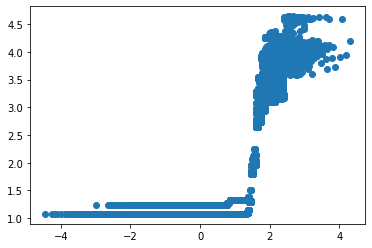

In [49]:
plt.plot(X[:, 0], y_pred, 'o')

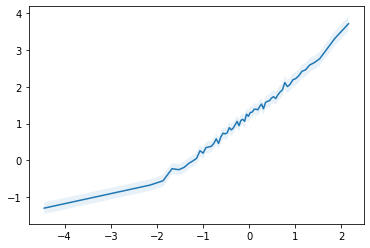

In [135]:
from sgp.trees.binarizer import binarization_plot
bins_values, uplift_values, stds_values = binarization_plot(X[:, 0], tr, y, n_bins=64)

plt.plot(bins_values, uplift_values)
plt.fill_between(bins_values, uplift_values - 3 * stds_values, uplift_values + 3 * stds_values, alpha=0.1)
plt.show()

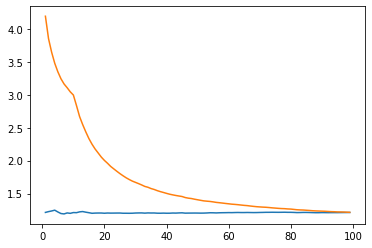

In [134]:
from sgp.trees.loss import uplift_at_k

random_y_pred = y_pred.copy()
np.random.shuffle(random_y_pred)
plt.plot(uplift_at_k(random_y_pred, y, tr)[::1000])

plt.plot(uplift_at_k(y_pred, y, tr)[::1000])